# Binary classifier to predict NV-HAP versus ventilated pneumonias

In [1]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from xgboost import XGBClassifier
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, average_precision_score

cwd = Path.cwd()
print(cwd)
datasets = cwd / '../results/tax_classification_out/abundance_matrices'
results = cwd / '../results/ML_out'

/mnt/c/git_repos/pneumonia/ML_scripts


/home/cednotsed/miniconda3/envs/mashin/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

### Load data

In [2]:
raw_df = pd.read_csv(datasets / 'RA.G.zeroed.decontam.2.csv')
meta = pd.read_csv(cwd / "../data/metadata/parsed_patient_metadata.filt.csv")
# display(raw_df)
# display(meta)

merged_df = raw_df.merge(meta, on='run_id', how='left')
merged_filt = merged_df.loc[merged_df.hap_vap_cap.isin(['HAP', 'VAP']), :]

print(merged_filt.loc[:, 'hap_vap2'].value_counts())
print(merged_filt.loc[:, 'ventilation'].value_counts())
# Response
y = merged_filt.loc[:, 'ventilation'].copy()

# Features
X = merged_filt.loc[:, ~merged_filt.keys().isin(meta.keys())].copy()

# # Add sample type
# X.insert(0, 'sample_type', merged_filt.loc[:, 'sample_type'])

# # Categorical encode variables
# X.replace({'sample_type': {'SPU' : 1, 'ETT' : 2, 'ND-BAL' : 3, 'BAL': 4}}, inplace=True)

# Rename features
X.columns = X.columns.str.replace('[^A-Za-z0-9]+', '_') 
print(X.shape)
print(y.shape)

# Binary encode y
y.loc[y == 'HAP'] = 1
y.loc[y == 'VAP'] = 0
y = y.astype('int')
# y.value_counts()

hap_vap2
VAP       127
V-HAP      45
NV-HAP     44
Name: count, dtype: int64
ventilation
True     172
False     44
Name: count, dtype: int64
(216, 152)
(216,)


In [3]:
n_splits = 5

pos = len(y[y == 1])
neg = len(y[y == 0])
split_sizes = pd.DataFrame({'HAP': [pos - int(pos / n_splits), int(pos / n_splits)], 
                           'VAP': [neg - int(neg / n_splits), int(neg / n_splits)]}, index=['Train fold', 'Test fold'])

display(split_sizes)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,HAP,VAP
Train fold,138,36
Test fold,34,8


## Model training and evaluation

In [4]:
def optimise_evaluate(X, y):
    np.random.seed(66)
    ratio = sum(y == 0) / sum(y == 1)
    
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(100, 1000, 100)
    max_depth = range(1, 5, 1)
    # gamma = np.linspace(0.1, 3, 10)
    colsample_bytree = np.linspace(0.1, 1, 10)
    
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      colsample_bytree=colsample_bytree)
                      # gamma=gamma,)
    
    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Inner CV
    model = GridSearchCV(model, 
                         param_grid, 
                         scoring='f1',
                         n_jobs=16, 
                         cv=inner_cv, 
                         verbose=1)

    model.fit(X, y)
    best_params = model.best_params_
    print(best_params)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)
    
    scoring = {'precision': precision, 
               'recall': recall, 
               'AUROC': 'roc_auc',
               'F1': f1}

    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring)
    outer_results = pd.DataFrame(outer_results).mean()[['test_precision', 'test_recall', 'test_F1', 'test_AUROC']]

    return outer_results, best_params


In [5]:
raw_results, raw_params = optimise_evaluate(X, y)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
{'colsample_bytree': 0.1, 'max_depth': 1, 'n_estimators': 100}
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [6]:
raw_results

test_precision    0.825943
test_recall       0.918151
test_F1           0.867232
test_AUROC        0.647740
dtype: float64

In [7]:
print(raw_params)
res_df = pd.DataFrame(raw_results).transpose()
res_df.to_csv(results / 'raw_results/vent_nonvent.csv', index=False)

{'colsample_bytree': 0.1, 'max_depth': 1, 'n_estimators': 100}


In [8]:
# From XGboost_external_validation notebook
# raw_params = {'subsample': 0.8, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 220, 'max_depth': 4, 'gamma': 0.1, 'colsample_bytree': 0.1473684210526316}
raw_model = XGBClassifier(**raw_params)
raw_model.fit(X, y)

explainer_raw = shap.TreeExplainer(raw_model, model_output='probability', data=X)
shap_raw = explainer_raw.shap_values(X)

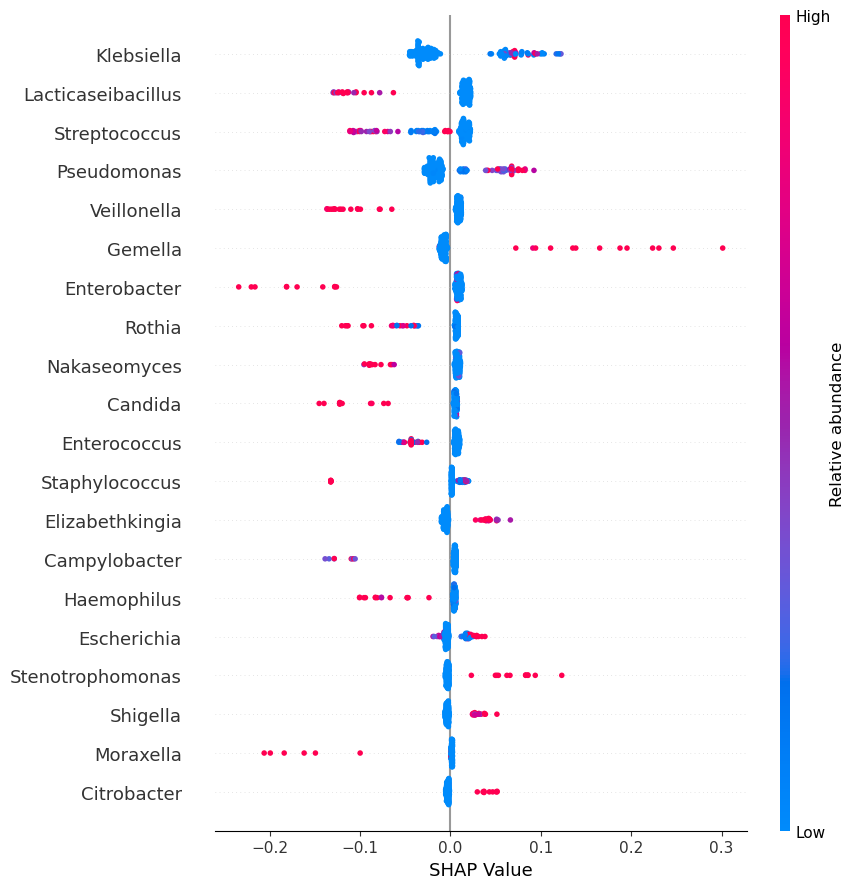

In [9]:
pre_model = XGBClassifier(**raw_params)
pre_model.fit(X=X, y=y)

pre_explainer = shap.TreeExplainer(pre_model, model_output='probability', data=X)
shap_pre = pre_explainer.shap_values(X)

shap.summary_plot(shap_pre, X, 
                  show=False, 
                  plot_size=(9, 9), 
                  color_bar_label='Relative abundance',
                  max_display=20)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'shap_plot.vent_nonvent.pdf', dpi=600)